# Terms Definition

## Markov Decision Process
MDPs are meant to be a straightforward framing of the problem of learning from
interaction to achieve a goal. The learner is called the agent, and the
thing it interacts with, is called the environment.
These interact continually, the agent selecting actions ($\mathcal{A}$) and the environment responding to
these actions and leads the agent to next states ($\mathcal{S}$). The environment also gives
rise to rewards ($\mathcal{R}$), special numerical values that the agent seeks to maximize over time
through its choice of actions. The environment's dynamic of MDP defined by function $p$,
and the expected reward for state-action pairs defined by function $r$.

The MDP framework is a considerable abstraction of the problem of goal-directed
learning from interaction. It proposes that whatever the details of the environment and whatever
the agent tries to achieve, any problem of
learning goal-directed behavior can be reduced to three messages passing back and forth
between an agent and its environment (actions, states and rewards).

Example for MDP problem can be learning to
control the motion of a robot arm in a repetitive pick-and-place task. If we want to learn
movements that are fast and smooth, the learning agent will have to control the motors
directly and have information about the current positions and velocities of the
mechanical linkages. The *actions* in this case might be the voltages applied to each motor
at each joint, and the *states* might be the latest readings of joint angles and velocities.
The *reward* might be +1 for each object successfully picked up and placed. To encourage
smooth movements, on each time step a small, negative reward can be given as a function
of the moment-to-moment “jerkiness” of the motion.

## State-Value Function
The state-value function, $v_\pi(s)$, of a MDP is the expected
return starting from state $s$ and then following policy $\pi$. The mathematical definition is:

$$v_\pi(s) = \mathbb{E}_{\pi}[G_t | S_t = s]$$

In other words, state-value function tells us
how good is it to be in state $s$ and following policy $\pi$.

## Action-Value Function
The action-value function $q_\pi(s,a)$ is the expected return
starting from state $s$, taking action $a$ and then following policy $\pi$. The mathematical definition
is:

$$q_\pi(s) = \mathbb{E}_{\pi}[G_t | S_t = s, A_t = a]$$

Action-value function tells us how good is it to
take a particular action from a particular state. Gives us an idea on what action we should take at states.

## Reward Function
A reward function is a function which represent the reward the agent gets. The reward
can be influence by the state ($s$), action ($a$) and next state ($s'$). The most common forms of reward functions are:

- $r(s): S \rightarrow \mathbb{R}$ - reward for being in state $s$.
- $r(s,a): S \times A \rightarrow \mathbb{R}$ - reward for being in state $s$ and applying action a.
- $r(s,a, s'): S \times A \times S \rightarrow \mathbb{R}$ - reward for being in state $s$, applying action $a$ and

move to state $s'$.

## Policy
A policy $\pi$ mapping from states to actions. There are two types
of policies - deterministic policy ($\pi(s_t) = a_t$) and stochastic policy ($\pi(a|s) = p(A_t = a | S_t = s, \pi)$).
The deterministic policy map for each state a specific action, and the stochastic
policy map for each state probability for each action. The optimal policy $\pi*$ maximize the expected total future rewards.

## Bellman Equations
The Bellman equations proposed to find the state-value function
and action-value function for a given MDP. The Bellman equations decompose the $v_\pi(s)$ and
$q_\pi(s,a)$ into two parts, the immediate reward plus the discounted future values. The
immediate reward represented by the reward function $\mathcal{R}$, the future values
represented $v_\pi(s')$ or $q_\pi(s',a')$ and discounted using $\gamma$. Using Bellman
equations we can find the expected values (Bellman expectation) or optimal values (Bellman optimality).

## Dynamic Programming
Dynamic programming (DP) refers to a collection of algorithms that can be
used to compute optimal policies given a perfect model of the environment as a MDP. The key idea of DP is the use of
value functions to organize and structure the search for good policies.
DP algorithms are obtained by turning Bellman equations into assignments, that is, into update rules for
improving approximations of the desired value functions.

## Value Iteration
Value iteration is an algorithm for finding the optimal policy for a given MDP.
Value iteration is obtained simply by turning the Bellman optimality equation into an update rule. The algorithm
iteratively solve the Bellman optimality equation and then derived the optimal policy from it.
The algorithm terminate once the value function changes by only a small amount in a sweep
(one update of each state).

## Policy Iteration
Policy iteration algorithm is an algorithm for finding the optimal
policy for a given MDP. The algorithm consists of two steps - policy evaluation and
policy improvement. In policy evaluation step we computes the state-value function
$v_\pi$ for a given policy $\pi$. In the policy improvement step we select for each state
the action that appear best according to the value function we got from the current policy evaluation step.
Then we got a new and better policy $\pi'$.
Once a policy, $\pi$, has been improved using $v_\pi$ to yield a better policy, $\pi'$
,we can then compute $v_\pi'$ and improve it again to yield an even better $\pi''$. Policy iteration algorithm
obtain a sequence of these monotonically improving policies and value functions until reaching the optimal policy $\pi*$
and optimal value function $v_\pi*$.

## Reinforcement Learning
Reinforcement learning (RL) is learning what to do, i.e., how to map states to actions, so
as to maximize a numerical reward. The learner is not told which actions to
take, but instead must discover which actions yield the most reward by trying them. Problems that can be solved using
RL need to have the follows conditions:

- The learner must be able to sense the state of its environment.
- The learner must be able to take actions that effect the state.
- The learner must have a goal or goals relating to the state of the environment.

Unlike MDP in RL the transition model $\mathcal{P}$ and the reward matrix $\mathcal{R}$ are not explicitly known
to the agent. The agent can use his experience to reveal these two environment's parameters and improve its performance
over time.

An example RL problem could be a gazelle struggles to its feet minutes
after being born. Half an hour later it is running at 20 miles per hour. The gazelle
uses its experience from interacting with the environment to improves the efficiency with which it can run.
The gazelle started with no prior knowledge about the environment.


# MDP Gridworld

First thing - import libraries.

In [1]:
%matplotlib inline
from PIL import Image
from IPython.display import display
import pickle
from MDP.World import World
from MDP.mdp import TransitionModel, RewardFunction, MDP

*Note*: Instead of plotting the value function and policy as part of code cells in the notebook I
saved them as images and load them in the notebook. The plots look bad when plotting them
directly to the notebook and I couldn't find any way to fix it.

## Transition Model & Reward Function

### Transition Model
For constructing the transition model I was needed to compute
4 different matrices, one for each action. For each action I computed the probability
for moving from state $s$ to state $s'$ using the action $a$. Then I construct it as a matrix where
the rows represent the 'from' state and the columns represent the 'to'. For example the probability
in cell $(3,4)$ represent the probability to move from state $3$ to state $4$ using the given action.

*Note*: I treated the obstacle as extended state, i.e., the state is not reachable at all.
Hence, it not part of the transition model and reward function.

The matrices can be seen in the appendix.

In [2]:
actions = ['north', 'east', 'south', 'west']
path = 'transition_model/{}.pkl'
tm_matrices = [pickle.load(open(path.format(a), 'rb')) for a in actions]

Now to make it easier to use I created a class names `TransitionModel` which wrap all the above-mentioned
matrices. The constructor of the class gets list of actions and list of probability matrices (as pandas DataFrames).
Then I implemented the method `prob` which computes the probability $p(s'|s,a)$. For example:

In [3]:
transition_model = TransitionModel(actions = [a[0] for a in actions],
                                   transition_matrices=tm_matrices)

print('P(s` = 1 | s = 5, a = N) = {}'.format(transition_model.prob(1, 5, 0)))

P(s` = 1 | s = 5, a = N) = 0.1


### Reward Function
In each transition from $s$ to $s'$ the robots get reward of $-0.04$. In transition
to the goal state or to a hole the robot gets **in addition** a reward of
$+1$ or $-1$ respectively. I constructed a reward function for each action, where
$r(s, a, s')$ will be larger than zero if and only if it possible to move from $s$ to $s'$ using
$a$ ($p(s'|s,a) > 0$). The reward matrices can be found in the appendix.

In [4]:
path = 'reward_function/{}.pkl'
reward_matrices = [pickle.load(open(path.format(a), 'rb')) for a in actions]

I implemented a class names `RewardFunction` which represent a reward function. The constructor
gets a list of actions and list of reward matrix for each action. Then I implements a method
to get easily the reward $r(s, a, s')$ by using the method `reward()` which gets ($s, a, s'$) and returns
the corresponded reward.

In [5]:
reward_function = RewardFunction(actions = [a[0] for a in actions],
                                 reward_matrices=reward_matrices)

print('r(s = 2, a = N, s` = 1) = {}'.format(reward_function.reward(2, 0, 1)))

r(s = 2, a = N, s` = 1) = -1.04


And now for the graphical model when action is 'North':

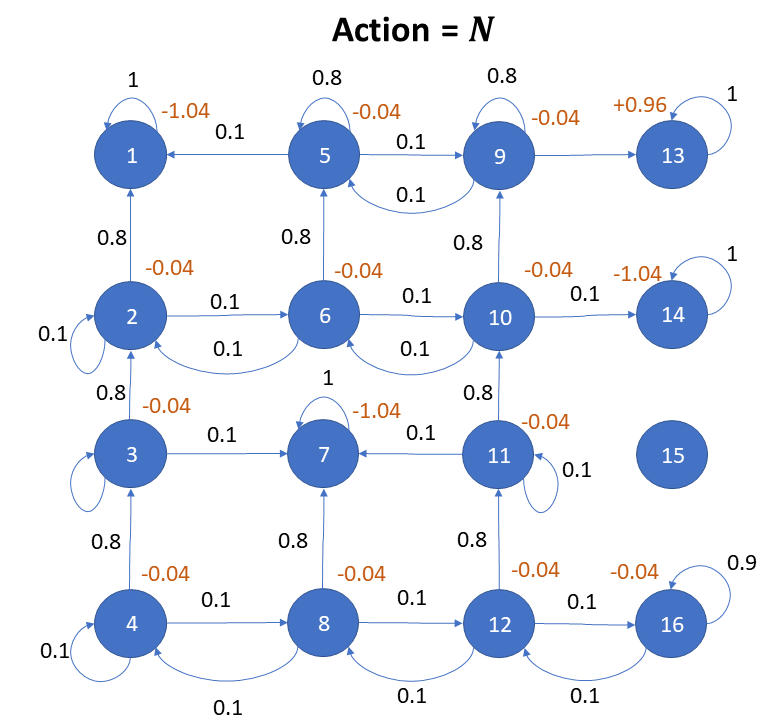

In [6]:
display(Image.open('images/MDP_north.png'))


## Value Iteration (I)

In order to solve the MDP using value iteration algorithm I implemented a method called `value_iteration`
which gets as input a threshold input $\theta$ and update the policy attribute in the MDP instance.
I used $\theta = 10^{-4}$ as threshold and $\gamma = 0.99$ as discount factor.

Now let's create a MDP instance and solve it while using the value iteration algorithm.

Solving MDP using value iteration algorithm...
Convergence after 14 iterations


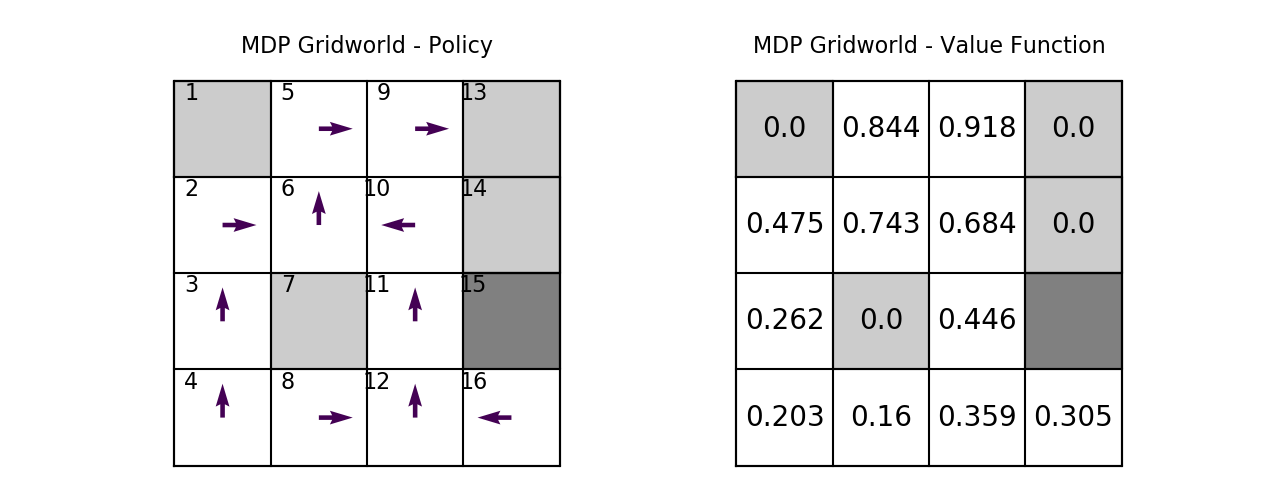

In [7]:
# Create a MDP instance
mdp = MDP(World(), transition_model, reward_function, gamma=0.99)

# Solve it using value iteration algorithm
mdp.value_iteration(theta=10 ** -4, verbose=True)
display(Image.open('images/section_b.png'))

So that seem like a great policy!

The only thing I was wondered about was the 0.0 at each terminal state.
I believe it because in the reward function I used $r(1, a, 1) = 0$ for example.
I assume it is correct because the definition we got for a $v(s)$ is: "the expected
return starting from state $s$", so if I start in a terminal state, I will
stay there and will have 0 cookies (I understand the problem as getting a cookie for entering
a terminal state, but if I already inside I will get nothing).

## Value Iteration (II)

Next I repeated the value iteration algorithm but now with $\gamma = 0.9$.
The gamma is a reflection of how you value your future reward. For example,
choosing $\gamma = 0$ would means that you are going for a greedy policy
where the long-term future does not matter at all.

Solving MDP using value iteration algorithm...
Convergence after 10 iterations


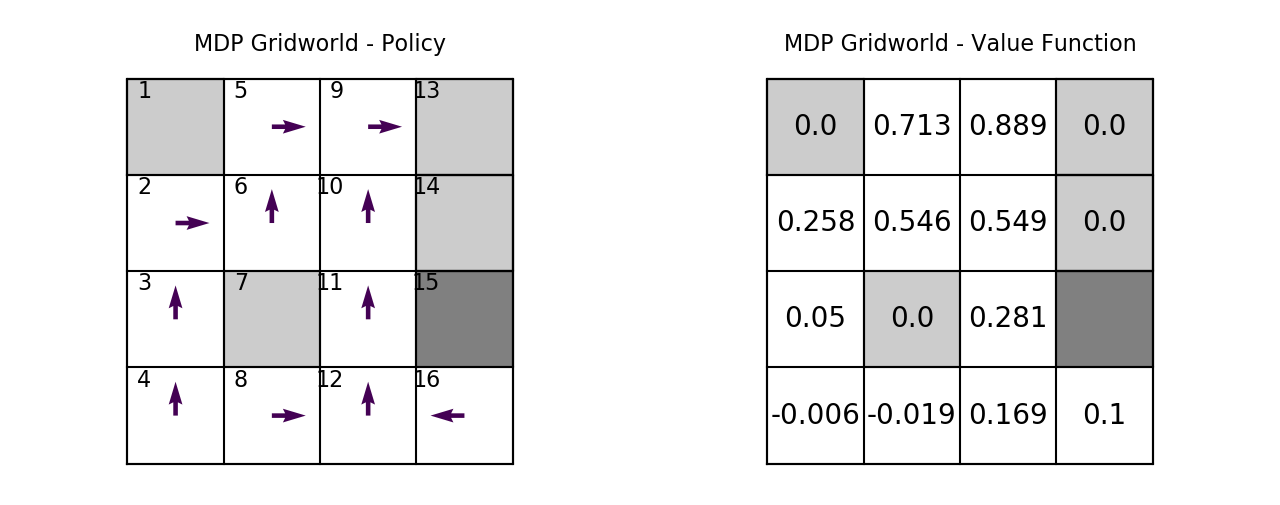

In [8]:
# Set new MDP object but now with gamma = 0.9
mdp = MDP(World(), transition_model, reward_function, gamma=0.9)

# Solve & Plot
mdp.value_iteration(theta=10 ** -4)
display(Image.open('images/section_c.png'))

First, about the value function, we can notice that the values are smaller than before.
This make sense because the equation we use for the optimal value function is $\mathcal{R}_s^a + \gamma \sum{p(s'|s,a)V(s')}$.
The expression $\mathcal{R}_s^a$ doesn't depend on gamma, so small gamma will make the right expression to be smaller.
Conceptually, smaller gamma will value less the future rewards, that's why the value
function of each state became smaller when using smaller gamma (in our problem conditions).

Over the policy, we can see the only change is:
$$\pi_{\gamma=0.99}(s_{10}) = W; \quad \pi_{\gamma=0.9}(s_{10}) = N$$

I think it because the fact that using smaller gamma will make the policy to be more greedy.
The second policy, i.e. $\gamma = 0.9$, see more cookies when going north, so it make this move despite
we can fall into the hole in the right. The first policy, i.e. $\gamma=0.99$, more "afraid" from future holes,
and hence decides to go west and avoid any future holes.

Last thing is the amount of iterations until converge - we can see using smaller
$\gamma$ influenced the number of iterations until converge of the algorithm.
I think it because changes in $V(s')$ have more weight when using larger $\gamma$.
For example using $\gamma=0$ will move greedy regardless to $V(s')$. So it make sense
that lower $\gamma$ leads to faster convergence and higher value will leads to slower convergence.

## Value Iteration (III)

Now we need to repeat the value iteration algorithm but with $\gamma = 0.9$ and $r = -0.02$.
I added to the `RewardFunction` class a staticmethod which gets a reward matrix, current
transition's reward and new transition reward and returns the reward matrix
with the new transition's reward. I used it to update the constructed reward matrices to fit
the section's demands. Then I used these matrices for the MDP:

Solving MDP using value iteration algorithm...
Convergence after 10 iterations


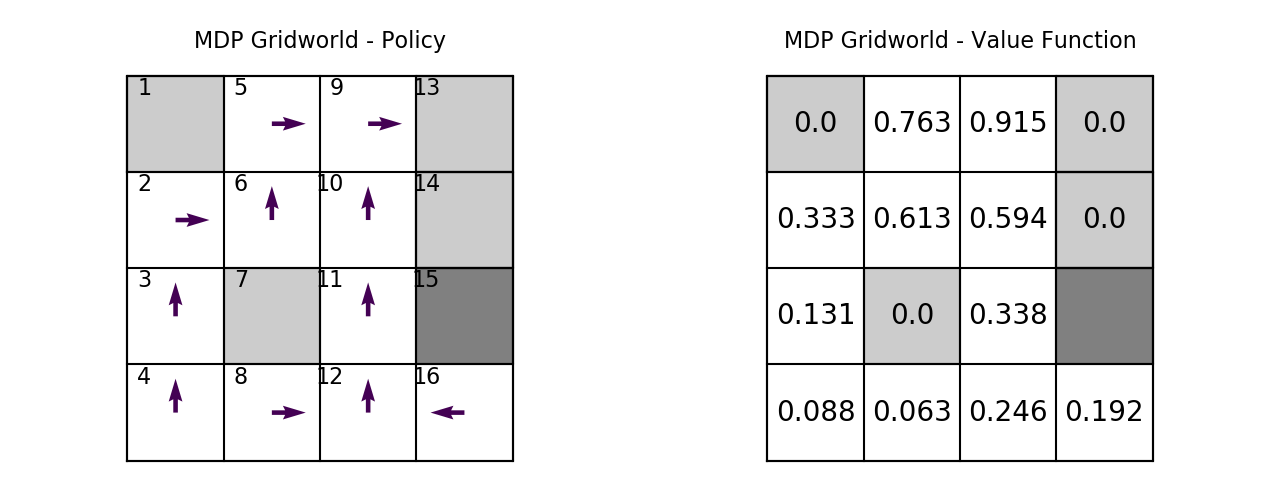

In [9]:
# Create the new reward function (r = -0.02)
new_reward_matrices = [RewardFunction.change_transition_reward(m, -0.04, -0.02)
                       for m in reward_matrices]
new_reward_function = RewardFunction(actions=[a[0] for a in actions],
                                     reward_matrices=new_reward_matrices)

# Solve & Plot
mdp = MDP(World(), transition_model, new_reward_function, gamma=0.9)
mdp.value_iteration(theta=10 ** -4)
display(Image.open('images/section_d.png'))


About the value function - we can notice that all values became larger compared
to section c. It make sense because we increased $r$ (paying less for each transition)
so larger values were expected.

About the policy - it stay the same as section c. It look like increasing
$r$ to -0.02 wasn't enough for the greedy policy to make a round in order to avoid
a possible fall to the hole in state 14.


## Policy Iteration

Now we use the policy iteration algorithm for solving the MDP problem. I used the following parameters
for the MDP:

- $\gamma = 0.9$
- $r = -0.04$
- $\theta = 10^{-4}$
- Initialize the policy with uniform random policy

*Notes*:

1. I Implemented the stop condition of the algorithm as Armin said in the lecture - after
both policy and value function do not change (and not only the policy as mentioned in Barto & Sutton algorithm).

1. In the policy evaluation step I implemented the *iterative policy evaluation* algorithm. Although our
problem can be solved also by *exact policy evaluation* I preferred to implement more generic
algorithm which be suitable for various types of MDP.

Solving MDP using policy iteration algorithm...
Convergence after 6 iterations


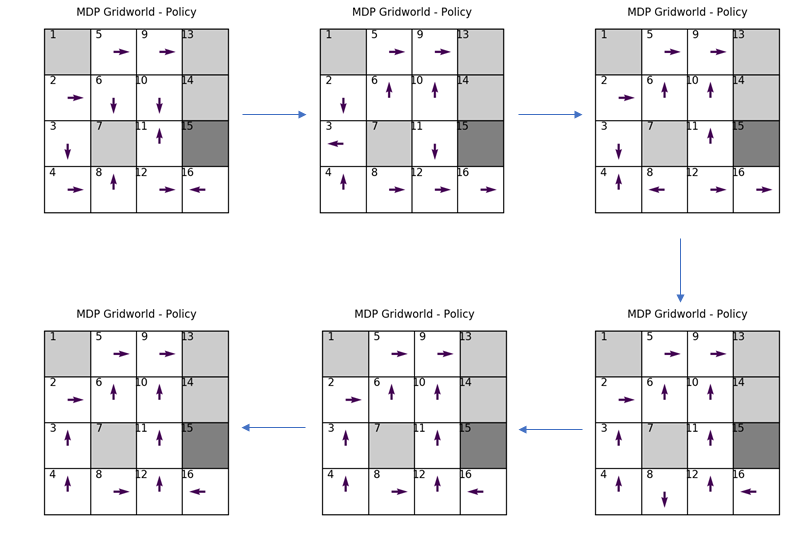

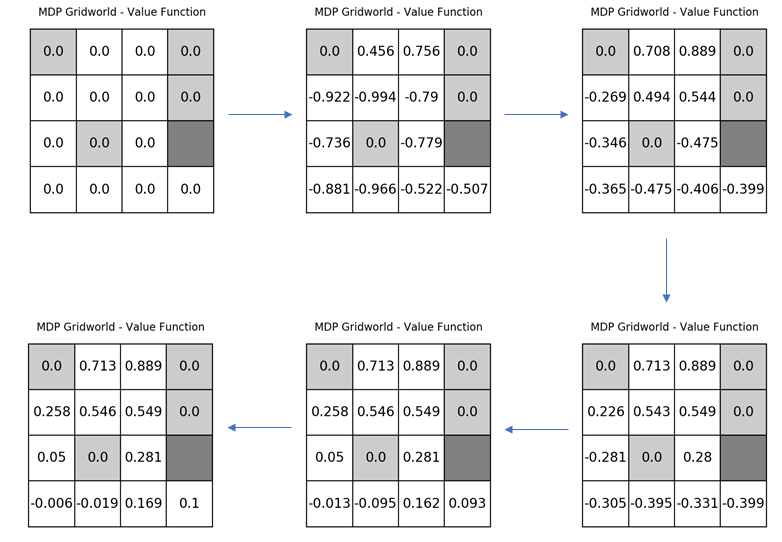

In [14]:
mdp = MDP(World(), transition_model, reward_function, gamma=0.9)
mdp.policy_iteration(theta=10 ** -4)
display(Image.open('images/section_e_policy.png'))
display(Image.open('images/section_e_values.png'))

As we can see, we got exactly the same policy and values when using value iteration algorithm.
That make sense because both algorithms look for the same optimal policy just in different ways.
Additionally, the policy converged to the optimal policy one iteration before the value function.

Regarding the amount of iteration - policy iteration algorithm succeed to find an optimal
policy after smaller amount of iterations. Despite the smaller amount of iteration, the policy
iteration algorithm is more computationally complex than value iteration. Hence, value iteration
can provide faster solution (depends on the environment).

# Appendix

## Transition Model

The rows represent the 'from' state and the column the 'to' state.

In [11]:
for i in range(len(actions)):

    print('\nAction = {}\n{}'.format(actions[i], tm_matrices[i]))


Action = north
     1    2    3    4    5    6    7    8    9    10   11   12   13   14   16
1   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2   0.8  0.1  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3   0.0  0.8  0.1  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4   0.0  0.0  0.8  0.1  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5   0.1  0.0  0.0  0.0  0.8  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0
6   0.0  0.1  0.0  0.0  0.8  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0
7   0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
8   0.0  0.0  0.0  0.1  0.0  0.0  0.8  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0
9   0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.8  0.0  0.0  0.0  0.1  0.0  0.0
10  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.8  0.0  0.0  0.0  0.0  0.1  0.0
11  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.8  0.1  0.0  0.0  0.0  0.0
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0 

## Reward Function

The rows represent the 'from' state and the column the 'to' state.

In [12]:
for i in range(len(actions)):

    print('\nAction = {}\n{}'.format(actions[i], reward_matrices[i]))


Action = north
      1     2     3     4     5     6     7     8     9     10    11    12  \
1   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
2  -1.04 -0.04  0.00  0.00  0.00 -0.04  0.00  0.00  0.00  0.00  0.00  0.00   
3   0.00 -0.04 -0.04  0.00  0.00  0.00 -1.04  0.00  0.00  0.00  0.00  0.00   
4   0.00  0.00 -0.04 -0.04  0.00  0.00  0.00 -0.04  0.00  0.00  0.00  0.00   
5  -1.04  0.00  0.00  0.00 -0.04  0.00  0.00  0.00 -0.04  0.00  0.00  0.00   
6   0.00 -0.04  0.00  0.00 -0.04  0.00  0.00  0.00  0.00 -0.04  0.00  0.00   
7   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
8   0.00  0.00  0.00 -0.04  0.00  0.00 -1.04  0.00  0.00  0.00  0.00 -0.04   
9   0.00  0.00  0.00  0.00 -0.04  0.00  0.00  0.00 -0.04  0.00  0.00  0.00   
10  0.00  0.00  0.00  0.00  0.00 -0.04  0.00  0.00 -0.04  0.00  0.00  0.00   
11  0.00  0.00  0.00  0.00  0.00  0.00 -1.04  0.00  0.00 -0.04 -0.04  0.00   
12  0.00  0.00  0.00  0.00  0.00  0.00  0.00 -0.